# Домашнее задание №1

В этом домашнем задании вам предлагается обучить модель регрессии для предсказания стоимости автомобилей, а также реализовать веб-сервис для применения построенной модели на новых данных.

> Оценка за домашку = min(ваш балл, 10)


Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

import pickle

random.seed(42)
np.random.seed(42)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pd.options.mode.chained_assignment = None

Ниже ответьте на вопрос <font color='#FF6600'>
"Для чего фиксируем сиды в домашках?"</font>

In [3]:
print("Многие функции, мы которые применяем при обработке, анализе данных и предсказании новых значений используют сгенерированные случайные значения.\nОбычно это начальные значения для каких либо циклов.\nПоэтому что бы эксперименты, которые мы проводим, были воcпроизводимыми, необходимо вручную инициализировать генератор псевдослучайных чисел")

Многие функции, мы которые применяем при обработке, анализе данных и предсказании новых значений используют сгенерированные случайные значения.
Обычно это начальные значения для каких либо циклов.
Поэтому что бы эксперименты, которые мы проводим, были воcпроизводимыми, необходимо вручную инициализировать генератор псевдослучайных чисел


# Часть 1 (2.5 балла + 0.75) | EDA

## Простейший EDA и обработка признаков (1.5 балла + 0.25)

In [4]:
df_train = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


(0.15 балла) <font color='#9933CC'>Отобразите 10 **случайных** строк тренировочного датасета</font>

In [5]:
df_train.sample(10, random_state=42)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


(0.1 балла) <font color='#9933CC'>Отобразите первые 5 и последние 5 объектов тестового датасета</font>

In [6]:
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


In [7]:
df_test.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


In [8]:
# можно по другому
df_test[(df_test.index <= 4) | (df_test.index >= len(df_test) - 5)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


(0.1 балла) <font color='#9933CC'>Посчитайте основные статистики как по числовым, так и по категориальным столбцам для трейна и теста</font>. 
> Подсказка: ``.describe()`` с нужным(и) аргументом(-ами)



Реализовал разными способами, можно применять в зависимости от потребности. Мне более удобным показался II способ

In [9]:
# I способ
df_train.describe(include='object')

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


In [10]:
df_test.describe(include='object')

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


In [11]:
df_test.describe()

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


In [12]:
df_test.describe()

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


In [13]:
# II способ
df_train.describe(include= 'all')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
count,6999,6999.000000,6.999000e+03,6.999000e+03,6999,6999,6999,6999,6797,6797,6803,6796,6797.000000
unique,1924,NaN,NaN,NaN,4,3,2,5,386,120,316,419,NaN
top,Maruti Swift Dzire VDI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,NaN
freq,116,NaN,NaN,NaN,3793,5826,6095,4587,197,885,330,468,NaN
mean,NaN,2013.818403,6.395152e+05,6.958462e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.419008
std,NaN,4.053095,8.089419e+05,5.772400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965767
min,NaN,1983.000000,2.999900e+04,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
25%,NaN,2011.000000,2.549990e+05,3.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,2015.000000,4.500000e+05,6.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
75%,NaN,2017.000000,6.750000e+05,9.700000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [14]:
df_test.describe(include= 'all')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
count,1000,1000.000000,1.000000e+03,1000.000000,1000,1000,1000,1000,981,981,981,981,981.000000
unique,621,NaN,NaN,NaN,4,3,2,5,237,88,182,226,NaN
top,Maruti Alto 800 LXI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm,NaN
freq,15,NaN,NaN,NaN,534,837,877,623,23,116,43,57,NaN
mean,NaN,2013.681000,6.179010e+05,71393.341000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.410805
std,NaN,4.012149,7.585539e+05,48486.218662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.919985
min,NaN,1995.000000,3.100000e+04,1303.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000
25%,NaN,2011.000000,2.500000e+05,37000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,2014.000000,4.349990e+05,61500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
75%,NaN,2017.000000,6.700000e+05,100000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


(0.15 балла) <font color='#9933CC'>Посмотрите, есть ли в датасете пропуски.</font>

<font color='#FF6600'>Если есть, то в каких колонках?</font>



Ниже словарь в котором словарь состоит из: "название колонки": <количество NaN>

In [15]:
# Количество пропусков в train
is_null_dict = df_train.isna().sum().to_dict()
null_columns_train = {k:v for k,v in is_null_dict.items() if v != 0}
null_columns_train

{'mileage': 202, 'engine': 202, 'max_power': 196, 'torque': 203, 'seats': 202}

In [16]:
# Количетсво пропусков в test
is_null_dict = df_test.isna().sum().to_dict()
null_columns_test = {k:v for k,v in is_null_dict.items() if v != 0}
null_columns_test

{'mileage': 19, 'engine': 19, 'max_power': 19, 'torque': 19, 'seats': 19}

(0.1 балла) <font color='#9933CC'>Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием</font> (целевую переменную следует исключить). Если есть, то сколько?

In [17]:
# Dataframe содержит все наблюдения, которые являются дубликатами без учета цены автомобиля
df_train_duplicated = df_train[df_train.drop(['selling_price'], axis=1).duplicated(keep=False)]

# количество дублированных элементов
len(df_train_duplicated)

1799

(0.15 балла) <font color='#9933CC'>Отобразите такие объекты</font>

In [18]:
df_train_duplicated

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
22,Maruti Baleno Delta 1.2,2016,575000,45000,Petrol,Individual,Manual,First Owner,21.4 kmpl,1197 CC,83.1 bhp,115Nm@ 4000rpm,5.0
26,Maruti Omni E MPI STD BS IV,2018,254999,25000,Petrol,Individual,Manual,First Owner,16.8 kmpl,796 CC,34.2 bhp,59Nm@ 2500rpm,8.0
27,Maruti Vitara Brezza LDi Option,2017,670000,70000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0
28,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
29,Maruti Omni 8 Seater BSIV,2012,150000,35000,Petrol,Individual,Manual,Second Owner,14.0 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6981,Ford Freestyle Titanium Plus Diesel BSIV,2018,750000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


(0.15 балла) <font color='#9933CC'>Удалите повторяющиеся строки</font>. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю

In [19]:
list_df_train_columns = list(df_train.columns)
list_df_train_columns.remove('selling_price')

# параметр keep='first' установлен по умолчанию
df_train = df_train.drop_duplicates(subset= list_df_train_columns, ignore_index=True)

In [20]:
assert df_train.shape == (5840, 13)

(0.1 балла) Чтоб все было по красоте, <font color='#9933CC'>обновите индексы строк таким образом, чтобы они шли от 0 без пропусков</font>

In [21]:
# параметром ignore_index=True обновил индексы
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1 bhp,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0


Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не слава богу. Давайте починим.

(0.25 балла) Задача такая: 
<font color='#9933CC'>
* убрать единицы измерения для признаков ``mileage, engine, max_power``. 
* кастануть эти столбцы столбцы к ``float``.
* удалить столбец ``torque``
</font>

> Все действия нужно производить над обоими датасетами

---
**Доп (0.25 балла):**
* <font color='#9933CC'>Вместо удаления признак `torque` разделите на два: собственно `torque` и `max_torque_rpm`.</font> Учтите единицы измерения. Они разные ☹

In [22]:
def delete_str_in_column(data, column: str):

    '''
    Функция получает на вход набор данных в формете pd.DataFrame, колонку датафрейма в формате str
    
    В dict_error попадают все значения, которые не удалось обработать 

    Возвращает: 
    * pd.Series с данными приведенным к типу float без единиц измерения 
    * словавь с наблюдениями которые не удалось обработать 
    * количество таких наблюдений
    '''

    column_data = data.loc[:, column].copy()
    dict_error = dict()
    for i in range(len(data)):
        try:
            column_data[i] = float(data[column][i].split()[0])
        except:
            column_data[i] = None
            dict_error[str(i)] = data[column][i]
    return column_data, dict_error, len(dict_error)

In [23]:
def norm_data(data, list_column):
    """
    Функция принимает набор данных в pd.DataFrame и список колонок над которыми применять функцию для изменения 
    Применяет преобразования на месте
    """
    for column_name in list_column:
        data[column_name], _, _ = delete_str_in_column(data, column_name)

In [24]:
list_column = ['mileage', 'engine', 'max_power']
norm_data(df_train, list_column)
norm_data(df_test, list_column)

In [25]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248.0,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396.0,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298.0,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0


In [26]:
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498.0,112.0,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497.0,108.5,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799.0,130.0,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498.0,98.6,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172.0,65.0,96 Nm at 3000 rpm,5.0


In [27]:
# можно было применить apply для этого, но захотелось реализовать свой вариант
# данных не на столько много, что бы возникали проблемы с производительностью
def torque_clear_data(data):
    
    """
    Функция получает на вход DataFrame
    При вызове функции создает в нем две колонки из колонки torque для удобства дальнейшей обработки 
    Возвращает список с индексами наблюдений, которые не получилось обработать 
    """

    data['torque_clear'] = data['torque'].copy()
    data['max_torque_rpm'] = data['torque'].copy()
    list_error_index = list()
    
    # цикл бежит по элементам колонки 
    for i in range(len(data['torque'])):

       # пробую обработать элемент колонки 
       try:
           value = data['torque'][i] # одно наблюдение в колонке

           # если крутящий момент выражен в кг/метр
           if 'kgm' in value.lower():
               kgm = re.sub("[^0-9.,]", " ", value).replace(',', '').split() # оставляю в строке только числа, точки и запятые, заменяю запятые для корректного разбиения и применяю split
               rpm = int(kgm[-1]) # выбираю из списка только число оборотов и привожу его к int
               kgm = int(float(kgm[0]) * 9.80665) # крутящий момент перевожу из кг/метр в Н/метр
               data['max_torque_rpm'][i] = rpm # количество оборотов в одну колонку
               data['torque_clear'][i] = kgm # крутящий момент в другую колонку

           # если крутящий момент выражен в Н/метр
           elif 'nm' in value.lower():
               nm = re.sub("[^0-9.,]", " ", value).replace(',', '').split() 
               rpm = int(nm[-1])
               nm = int(float(nm[0]))
               data['max_torque_rpm'][i] = rpm
               data['torque_clear'][i] = nm
            
            # если указаний измерения крутящего момента нет
           else:
               torque = re.sub("[^0-9.,]", " ", value).replace(',', '').split() 
               rpm = int(torque[-1])
               torque = int(float(torque[0]))
               data['max_torque_rpm'][i] = rpm
               data['torque_clear'][i] = torque
               
       # если возникает ошибка, то индекс в список индексов наблюдений, где возникла ошибка
       except:
           list_error_index.append(i) 

    return list_error_index

In [28]:
torque_clear_data(df_train)
torque_clear_data(df_test)
df_train.drop(['torque'], axis= 1, inplace= True)
df_test.drop(['torque'], axis= 1, inplace= True)

In [29]:
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_clear,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248.0,74.0,5.0,190,2000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,250,2500
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396.0,90.0,5.0,219,2750
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298.0,88.2,5.0,112,4500
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,5.0,113,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.1,5.0,96,3000
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9,998.0,67.1,5.0,90,3500
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5,1197.0,82.85,5.0,113,4000
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8,1493.0,110.0,5.0,235,2750


In [30]:
df_test

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_clear,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498.0,112.0,7.0,260,2200
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497.0,108.5,5.0,260,2750
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799.0,130.0,5.0,172,4300
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498.0,98.6,5.0,200,1750
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172.0,65.0,5.0,96,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81,1086.0,68.05,5.0,99,4500
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6,1197.0,81.83,5.0,114,4000
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0,1396.0,90.0,5.0,219,2750
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36,1197.0,78.9,5.0,111,4000


(0.15 балла) <font color='#9933CC'>Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось</font>

> Обратите внимание, что, по уму, нужно посчитать медиану по трейну и этим средним заполнять пропуски в тесте. Так же делаем, если, например, стандартизируем признаки.



In [31]:
# Количество пропусков в train
is_null_dict = df_train.isna().sum().to_dict()
null_columns_train = {k:v for k,v in is_null_dict.items() if v != 0}
null_columns_train

{'mileage': 186,
 'engine': 186,
 'max_power': 184,
 'seats': 186,
 'torque_clear': 187,
 'max_torque_rpm': 187}

In [32]:
# def fill_nan(data_train, data_test, dict_nan):
#     '''
#     Заменяю пропуски сразу в двух датасетах
#     '''
#     # цикл итерируется по ключам словаря, которые означают колонки с пропусками в данных
#     for i in dict_nan:
#         median = data_train[i].median()
#         data_test[i].fillna(median, inplace= True)
#         data_train[i].fillna(median, inplace= True)

In [33]:
# fill_nan(df_train, df_test, null_columns_train)

In [34]:
# вместо заполнения медианой использую импутер
col_nan = list(null_columns_train.keys())

imp = KNNImputer(n_neighbors=15)
imp.fit(df_train[col_nan])

df_train[col_nan] = imp.transform(df_train[col_nan])
df_test[col_nan] = imp.transform(df_test[col_nan])


(0.1 балла) Теперь, когда не осталось пропусков, можно <font color='#9933CC'>преобразовать столбцы к более подходящим типам (``engnine`` и ``seats`` к int)
</font>

Ниже ответьте, <font color='#FF6600'>почему (хоть мы этого и не делаем) ``seats``, возможно, лучше сделать переменной категориальной, а не целочисленной.</font>

In [35]:
print("Хоть переменная seats и ведет себя как число в плане того, что 5 seats это больше (и наверное лучше) чем 6 seats, он все же это число строго ограничено\n(от 2 до 8 в легковых автомобилях) и дискретно. Не бывает 1.5 места или 1.54328732 места. Поэтому, возможно, будет лучше расценивать seats как категории.")

Хоть переменная seats и ведет себя как число в плане того, что 5 seats это больше (и наверное лучше) чем 6 seats, он все же это число строго ограничено
(от 2 до 8 в легковых автомобилях) и дискретно. Не бывает 1.5 места или 1.54328732 места. Поэтому, возможно, будет лучше расценивать seats как категории.


In [36]:
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

## Визуализации (1 балл + 0.5)

Визуализировать нам надо не так уж и много. Во-первых, хотелось бы, в принципе, увидеть как распределены значения признаков. Также хотелось бы понять, насколько признаки скоррелированы между собой и с целевой переменной. А ещё неплохо бы посмотреть, не оказалось ли так, что тестовые данные распределены иначе, чем трейн.

Этим всем и предлагаем вам заняться.

(0.25 балла) <font color='#9933CC'>Посторойте попарные распределения всех числовых признаков для трейна.</font>

> ``sns.paiplot()`` позволяет сделать это в одну строчку

In [37]:
# список числовых признаков в df_train
num_features_df_train = [i for i in df_train.columns if (df_train[i].dtype == 'int') | (df_train[i].dtype == 'float')]
num_features_df_train

['year',
 'selling_price',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'seats',
 'torque_clear',
 'max_torque_rpm']

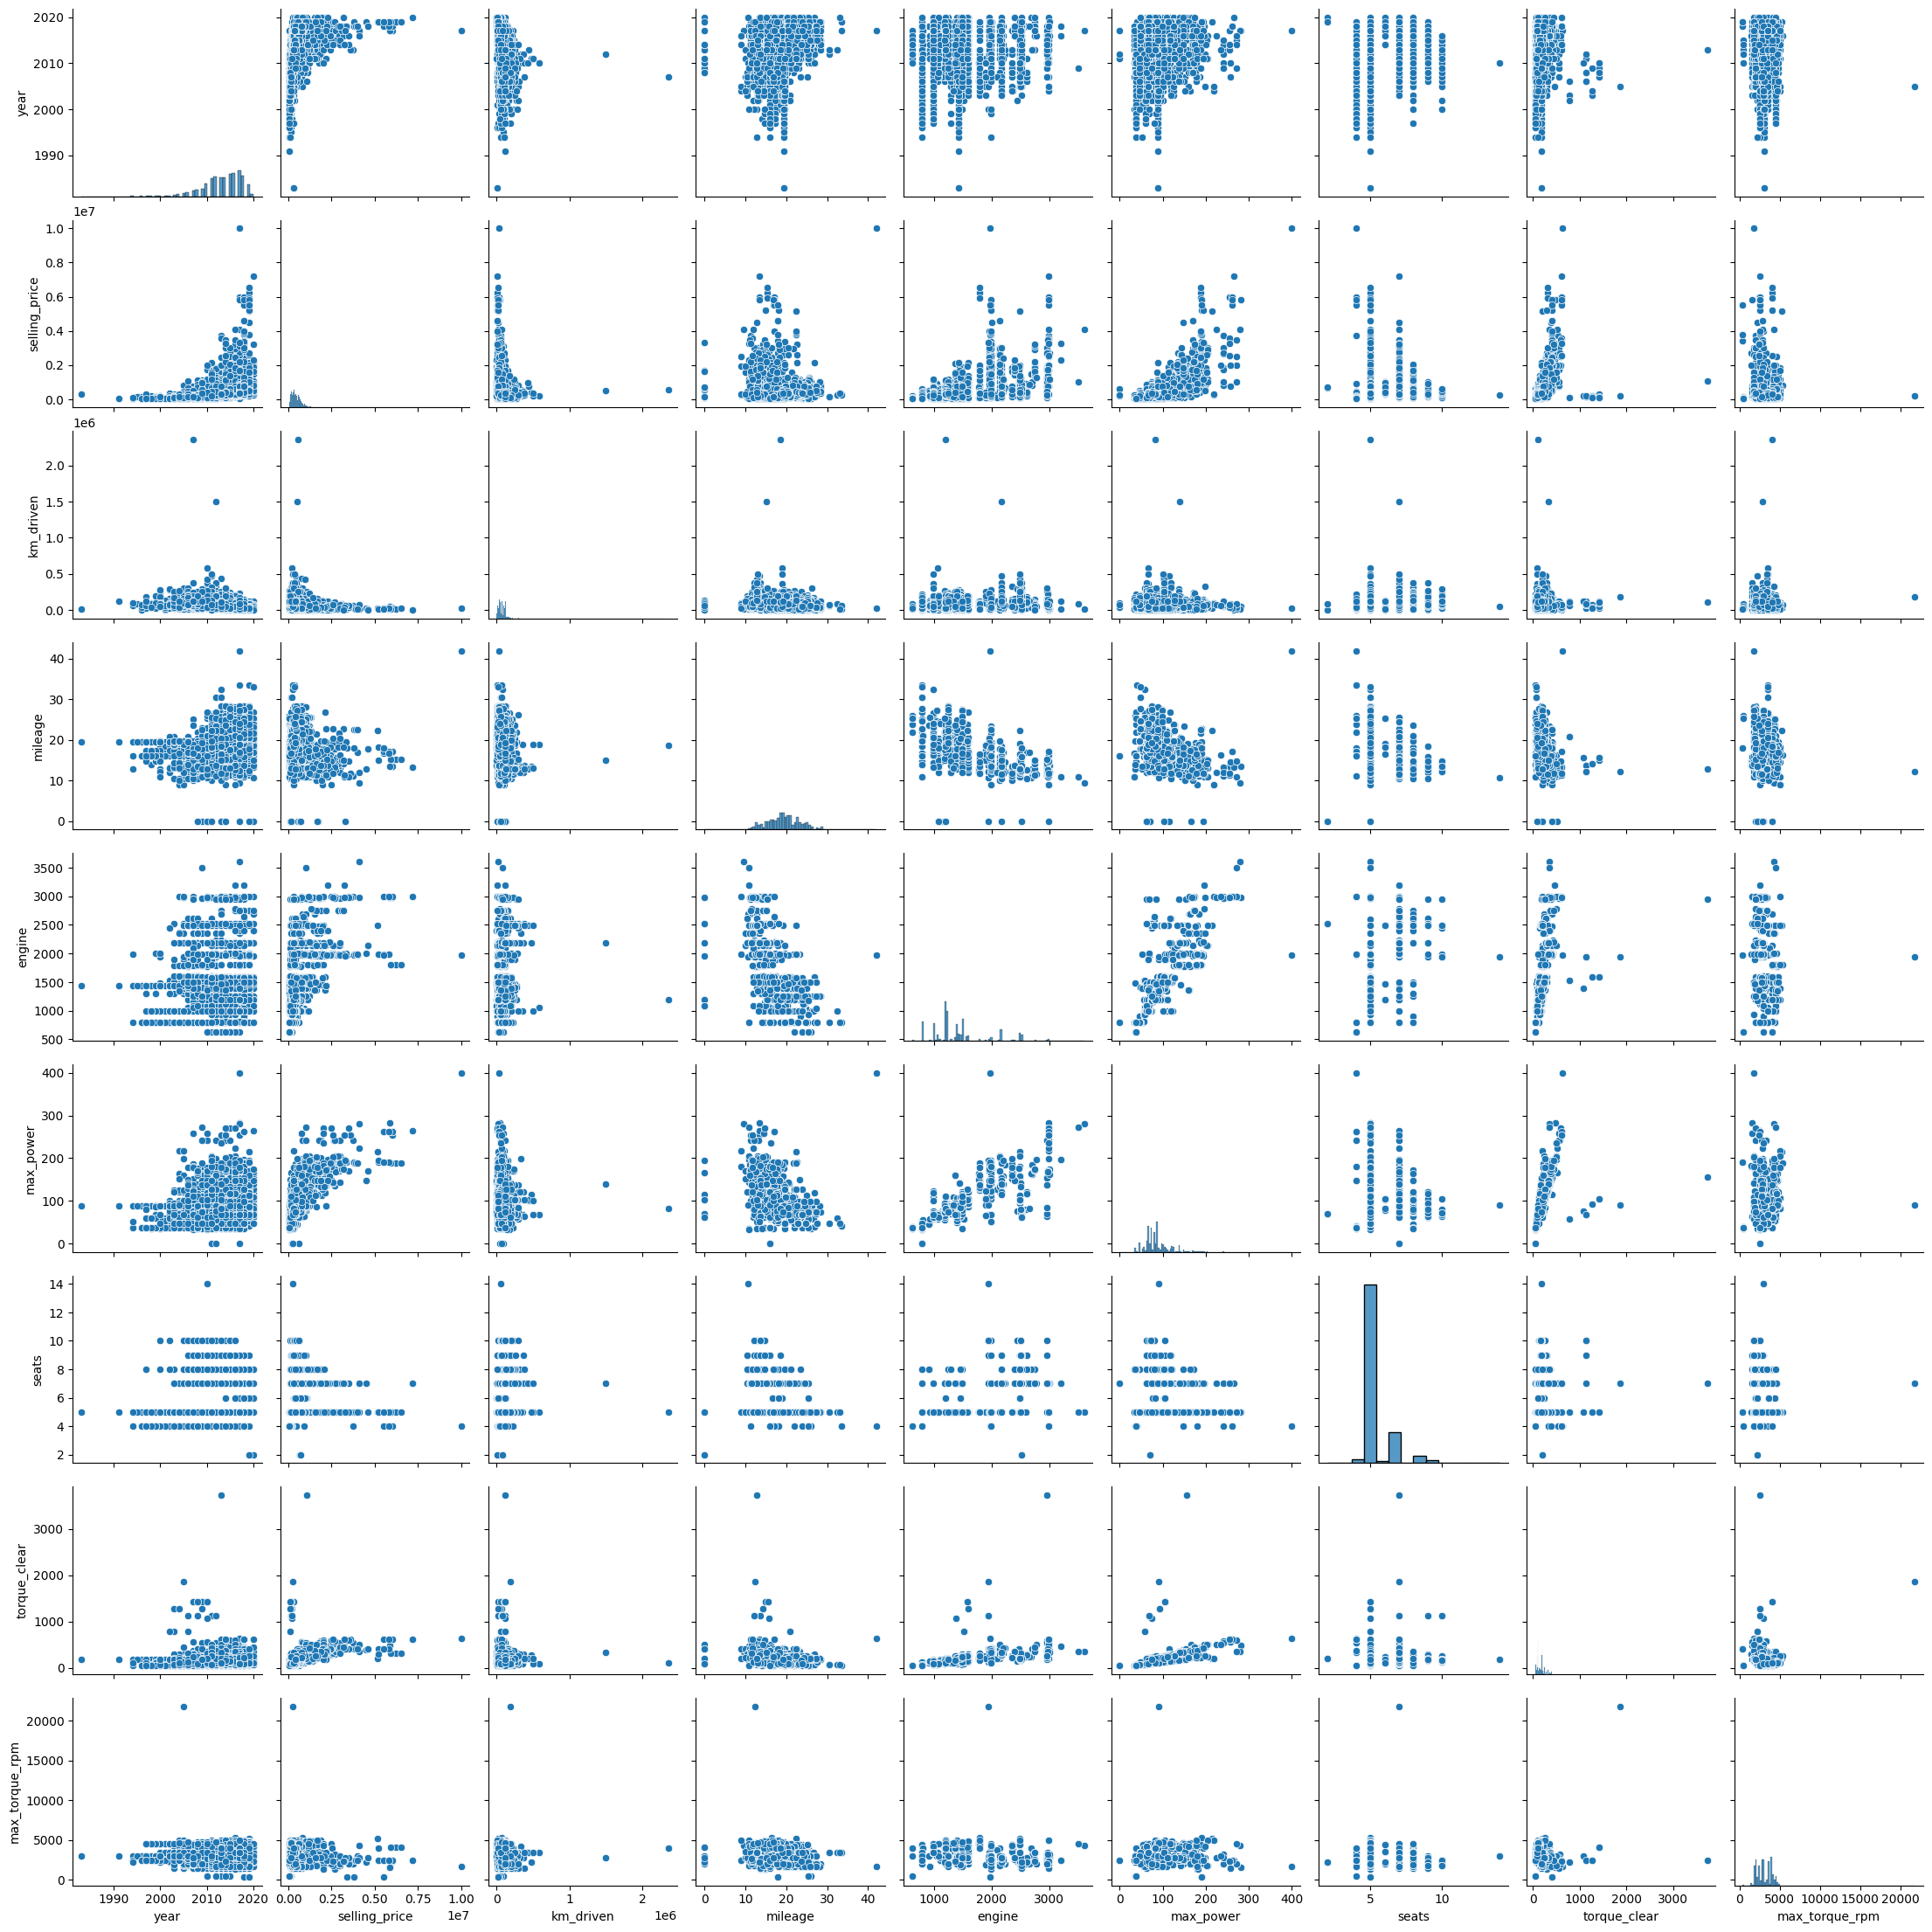

In [38]:
sns.pairplot(df_train[num_features_df_train]);

Этот график не такой информативный, как можно было бы построить, беря признаки по отдельности. Но он позволяет сделать некоторые (возможно, далеко идущие) выводы. Впрочем, со многими из них (если не со всеми) вы бы справились умозрительно. Однако всегда приятно делать выводы, основываясь на данных.

* <font color='#FF6600'> Что можно сказать о связи предикторов с целевой переменной? </font>

На этом графике видно, что есть линейная зависимость призанков с целевой переменной, например max_power, engine, torque_clear
и есть линейные зависимости между признаками, с чем предстоит разобраться 

* <font color='#FF6600'> А о корреляциях признаков? </font>

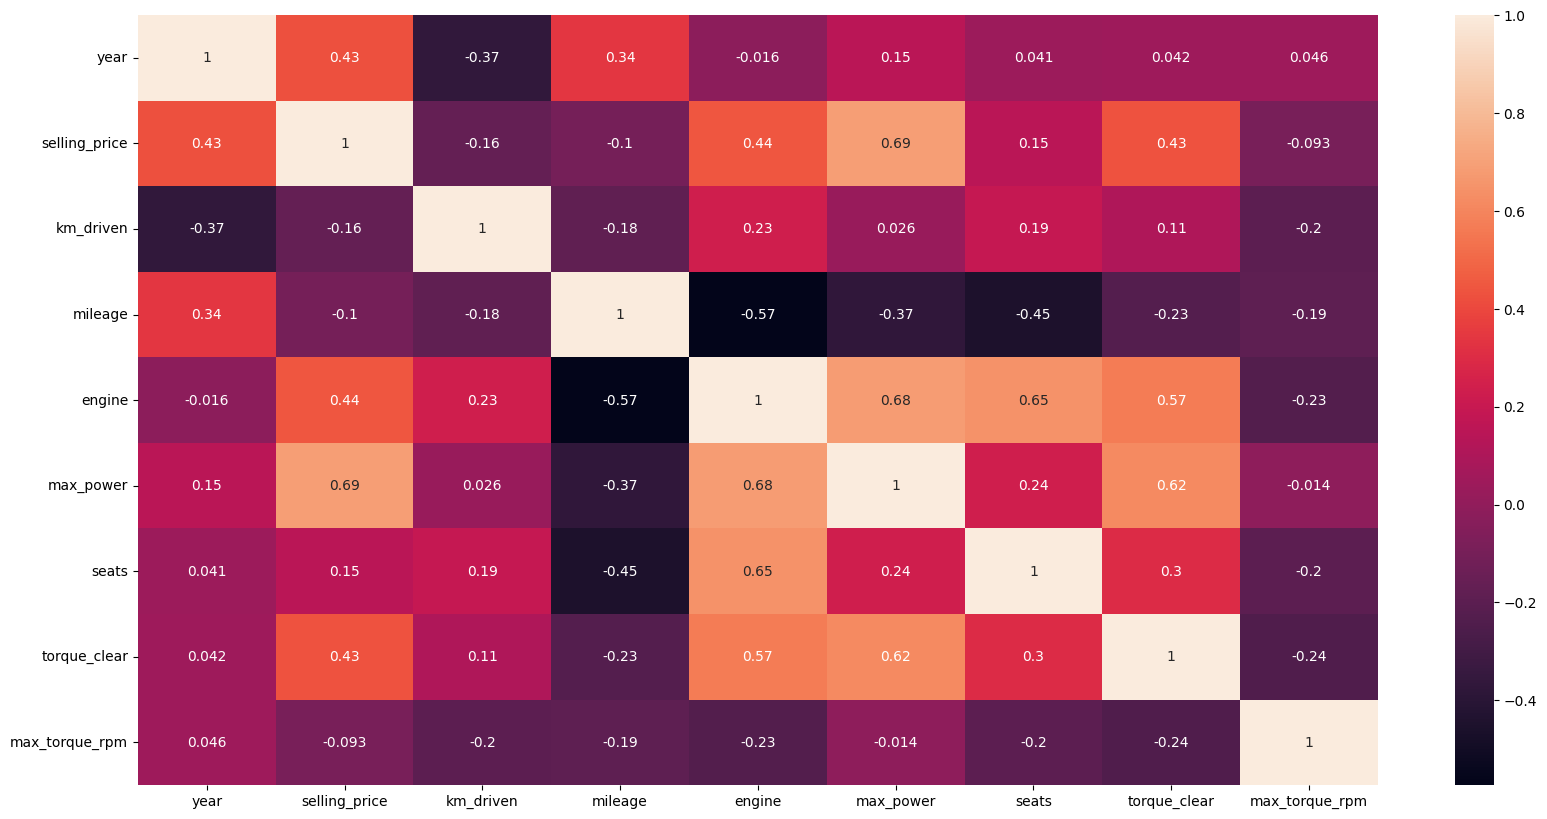

In [39]:
# для ответа на вопрос лучше построить матрицу корреляций
int_float_features = df_train[num_features_df_train]
corr_matrix_int_float = int_float_features.corr()
figure, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix_int_float, annot=True, ax=ax);

Исходя из данного графика можно сделать вывод о том, что у целевой переменной есть существенная линейная связь с такими признаками:
* year
* engine
* max_power
* torque_clear


Вместе с этим, присутствуют сильные линейные взаимосвязи между признаками:
* km_driven - year
* mileage - year
* engine - mileage
* max_power - mileage
* seats - mileage
* engine - max_power
* engine - seats
* engine - torque_clear
* torque_clear - max_power

(0.25 балла) <font color='#9933CC'>Постройте pairplot по тестовым данным</font> и ответьте на вопрос <font color='#FF6600'>"Похожими ли оказались совокупности при разделении на трейн и тест?"</font>

В целом, распределение признаков в train и test схожи, но по некоторым признакам сильно отличается дисперсия. Например, по признаку max_torque_rpm. Возможно это связано с большим количеством наблюдений в train и соответственно большей их "собранности" вокрун среднего значения этого признака

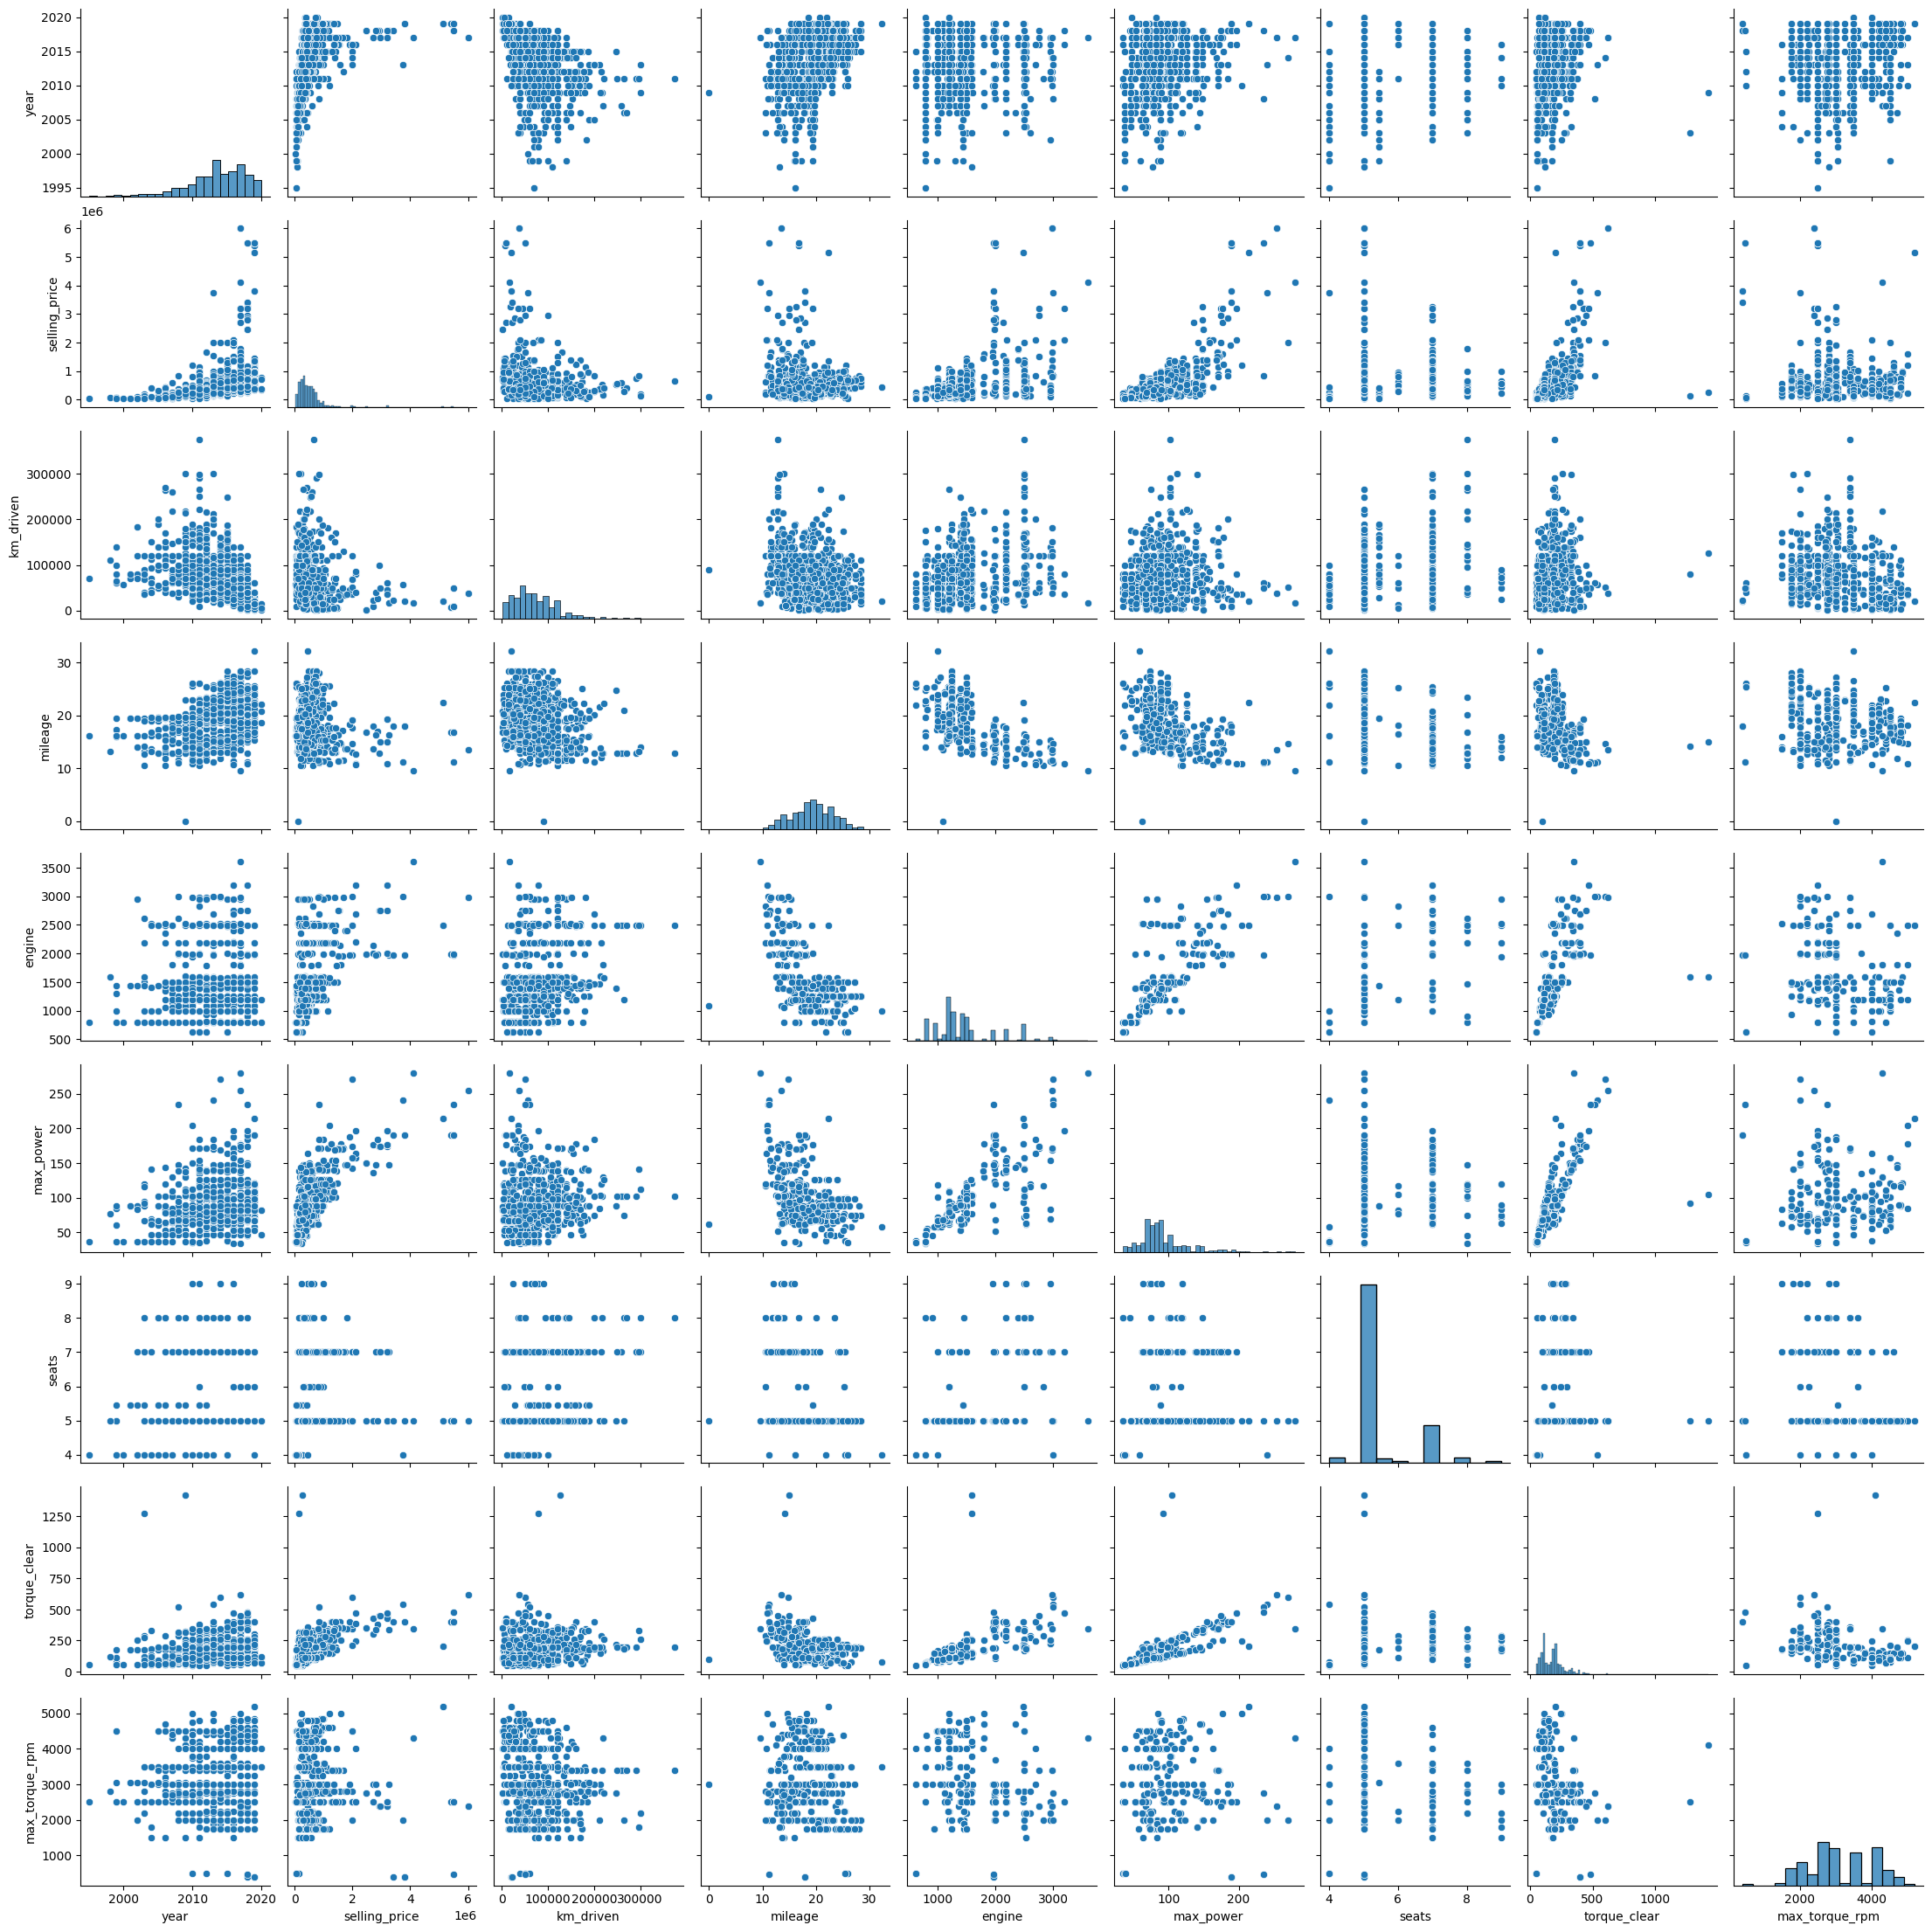

In [40]:
# список числовых признаков в df_test
num_features_df_test = [i for i in df_test.columns if (df_test[i].dtype == 'int') | (df_test[i].dtype == 'float')]
sns.pairplot(df_test[num_features_df_test]);

(0.25 балла) <font color='#9933CC'>Для трейна давайте построим тепловую карту (heatmap из библиотеки seaborn) попарных корреляций числовых колонок</font>

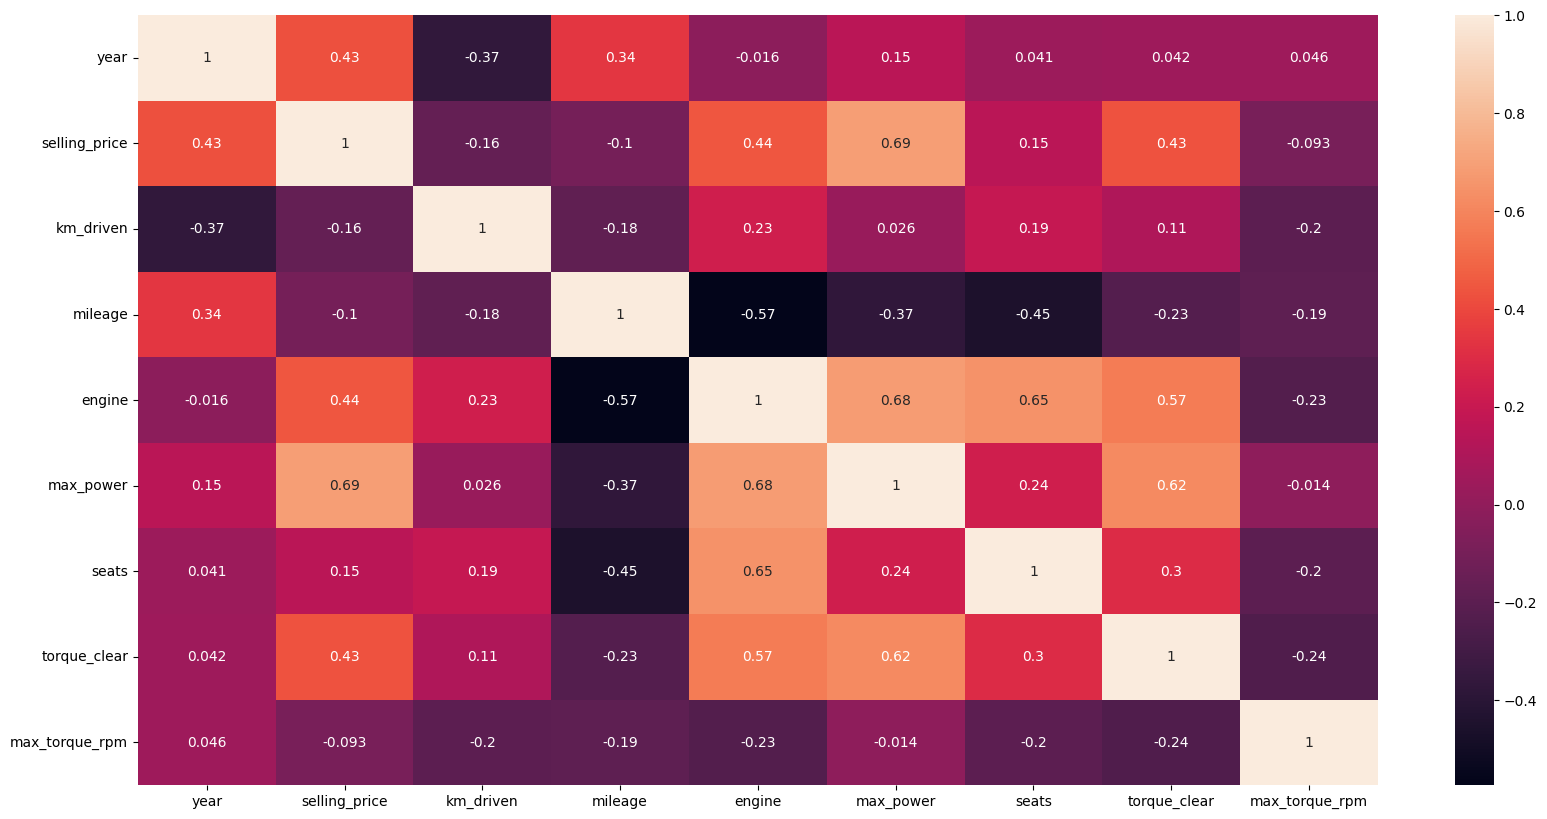

In [41]:
# еще раз строю тепловую карту корреляции
figure, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix_int_float, annot=True, ax=ax);

Ответьте, пожалуйста, на вопросы: 

* <font color='#FF6600'>Какие 2 признака наименее скоррелированы между собой?</font>

Ответ: max_power и max_torque_rpm

* <font color='#FF6600'>Между какими наблюдается довольно сильная положительная линейная зависимость?</font>

Ответ: 
* max_power - selling_price
* max_power - engine
* seats - engine
* torque_clear - max_power
* torque_clear - engine
* selling_price - engine
* selling_price - torque_clear
* selling_price - year

* <font color='#FF6600'>Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи.</font>

Ответ: судя по данным можно сделать такой вывод, визуально эта взаимосвязь особенно хорошо прослеживается в тестовых данных 

(0.25 балла) <font color='#9933CC'> Отобразите диаграммe рассеяния для наиболее скореллированной пары **признаков** (на трейне) </font>

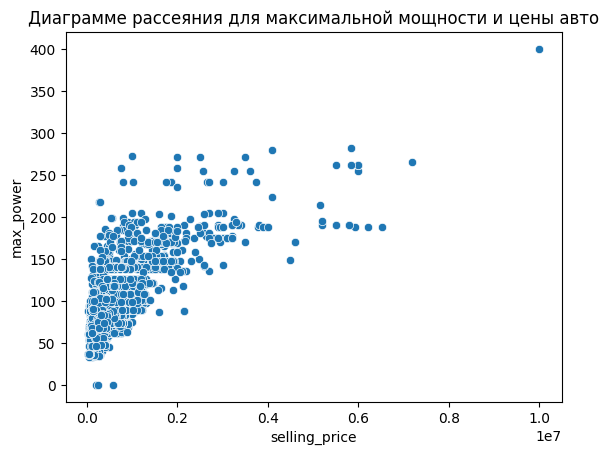

In [42]:
sns.scatterplot(data= df_train, x= "selling_price", y= "max_power").set(title= 'Диаграммe рассеяния для максимальной мощности и цены авто');

### Дополнительные визуализации (бонус 0.5 балла)

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

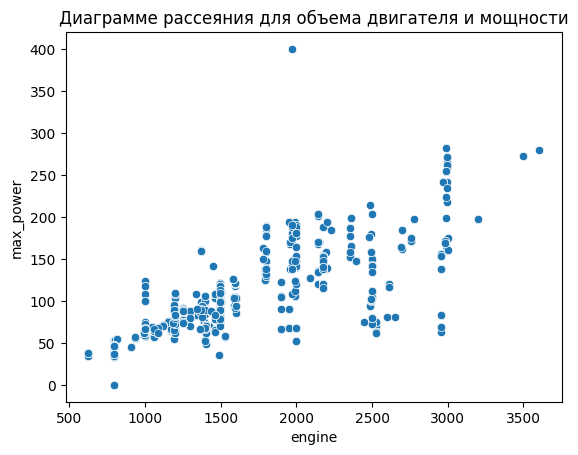

In [43]:
sns.scatterplot(data= df_train, x= "engine", y= "max_power").set(title= 'Диаграммe рассеяния для объема двигателя и мощности');

Интересно посмотреть хорошую линейную зависимость между объемом двигателя и мощностью двигателя

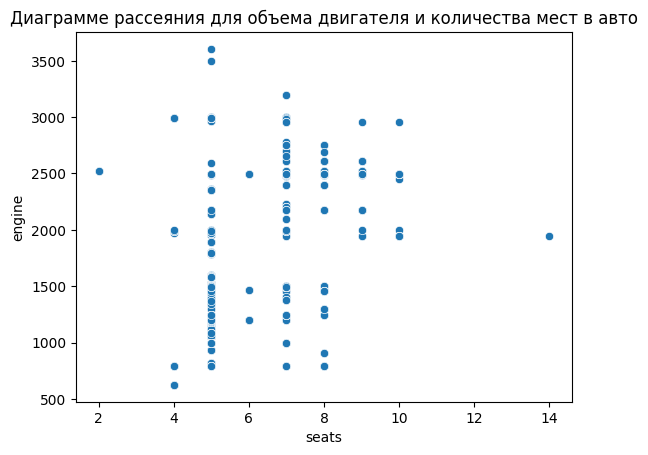

In [44]:
sns.scatterplot(data= df_train, x= "seats", y= "engine").set(title= 'Диаграммe рассеяния для объема двигателя и количества мест в авто');

На этом графике любопытно то, что коэфф. корреляции указывает на хорошую прямую линейную связь (чем больше количество мест, тем больше объем дв.), но на графике явно об этом сказть нельзя.  Посмотрим на гистограмму распределние признака seats: 

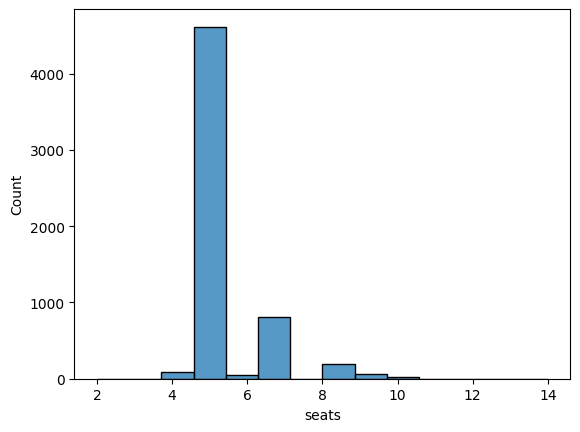

In [45]:
sns.histplot(data= df_train, x= "seats");

Предполагаю, что такой эффект возник из-за преобладания авто с количеством 5 и больше, поэтому на высокий коэфф. корр. я бы не расчитывал.

# Часть 2 (1.25 балла) | Модель только на вещественных признаках

(0.05 балла) <font color='#9933CC'>В переменные ``y_train`` и ``y_test`` запишите значения целевых переменных. Столбцы ``selling_price`` из датафреймов необходимо удалить. Категориальные (все, кроме ``seats``) столбцы тоже.</font>

In [46]:
# список объектовых признаков в df_train
object_features_df_train = [i for i in df_train.columns if df_train[i].dtype == 'O']
object_features_df_train

['name', 'fuel', 'seller_type', 'transmission', 'owner']

In [47]:
y_train = df_train['selling_price']

X_train = df_train.drop(object_features_df_train, axis=1)
X_train.drop(['selling_price'], axis=1, inplace= True)

In [48]:
assert X_train.shape == (5840, 8)

In [49]:
y_test = df_test['selling_price']
X_test = df_test.drop(object_features_df_train, axis=1)
X_test.drop(['selling_price'], axis=1, inplace= True)

In [50]:
assert X_test.shape == (1000, 8)

(0.2 балла) <font color='#9933CC'>Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и MSE для трейна и для теста</font>

**Замечание:** $R^2$ и MSE для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [52]:
def return_score(model, X_train_data, y_train_data, X_test_data, y_test_data):
    print(f" - Train MSE: {round(MSE(model.predict(X_train_data), y_train_data), 2)}")
    print(f" - Test MSE: {round(MSE(model.predict(X_test_data), y_test_data), 2)}")
    print()
    print(f" - Train R2: {round(r2_score(model.predict(X_train_data), y_train_data), 2)}")
    print(f" - Test R2: {round(r2_score(model.predict(X_test_data), y_test_data), 2)}")

In [53]:
print('Scores for LinearRegression:')
return_score(reg, X_train, y_train, X_test, y_test)

Scores for LinearRegression:
 - Train MSE: 114033216206.89
 - Test MSE: 226921340444.46

 - Train R2: 0.34
 - Test R2: -0.09


Запомните правило:

> Использую линейную модель -- стандартизирую фичи

(0.25 балла) <font color='#9933CC'>Воспользуемся им</font>


In [54]:
from sklearn.preprocessing import StandardScaler

scaller = StandardScaler()
X_train_scaller = pd.DataFrame(scaller.fit_transform(X_train))

# возвращаю названия колонкам после заполнения пропусков в train
for dq_c, df_c in zip(X_train_scaller.columns.to_list(), X_train.columns.to_list()):
    X_train_scaller.rename(columns = {dq_c : df_c}, inplace = True)

In [55]:
X_test_scaller = pd.DataFrame(scaller.transform(X_test))

# возвращаю названия колонкам после заполнения пропусков в test
for dq_c, df_c in zip(X_test_scaller.columns.to_list(), X_test.columns.to_list()):
    X_test_scaller.rename(columns = {dq_c : df_c}, inplace = True)

In [56]:
X_test_scaller

,year,km_driven,mileage,engine,max_power,seats,torque_clear,max_torque_rpm
0,-0.837167,1.565740,-1.362414,2.192854,0.755884,1.599681,0.717379,-0.914306
1,0.872122,-0.814974,0.518997,0.127751,0.645218,-0.435200,0.717379,-0.315349
2,-1.569719,2.405866,-1.638354,0.750789,1.325025,-0.435200,-0.036439,1.372619
3,0.383754,1.648982,1.422074,0.129814,0.332191,-0.435200,0.203412,-1.404361
4,-0.592983,-0.065798,-0.735277,-0.542738,-0.730206,-0.435200,-0.687462,-0.043096
...,...,...,...,...,...,...,...,...
995,-1.325535,0.433652,0.095052,-0.720159,-0.633768,-0.435200,-0.661764,1.590421
996,0.872122,-0.398765,-0.208482,-0.491162,-0.198059,-0.435200,-0.533273,1.045915
997,-1.081351,-0.565249,0.895279,-0.080616,0.060268,-0.435200,0.366168,-0.315349
998,-0.348799,-0.814974,0.233023,-0.491162,-0.290702,-0.435200,-0.558971,1.045915


In [57]:
reg.fit(X_train_scaller, y_train)

LinearRegression()

In [58]:
print('Scores for LinearRegression with StandardScaler:')
return_score(reg, X_train_scaller, y_train, X_test_scaller, y_test)

Scores for LinearRegression with StandardScaler:
 - Train MSE: 114033216206.89
 - Test MSE: 226921340444.46

 - Train R2: 0.34
 - Test R2: -0.09


Не очень результативно.

Зато уже сейчас можем интерпретировать модель. <font color='#FF6600'>"Какой признак оказался наиболее информативным в предсказании цены?"</font>

In [59]:
def calc_best_feature(features, odds):
    """
    Функция принимает на вход массивы фичей и коэффициентов линейной регрессии
    Возвращает признак с самым большим по модулю коэффициентом линейной модели
    """
    best_i = 0
    max_coef = 0
    for item in range(len(odds)):
        if abs(reg.coef_[item]) > max_coef:
            max_coef = reg.coef_[item]
            best_i = item
    return features[best_i]

In [60]:
# самый значимый признак модели
calc_best_feature(X_train_scaller.columns, reg.coef_)

'max_power'

(0.25 балла) <font color='#9933CC'>Теперь попробуем Lasso-регрессию.</font> Здесь и дальше обучайте модели на нормализованных признаках

In [61]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(random_state= 42)

lasso_reg.fit(X_train_scaller, y_train)

print('Scores for Lasso Regression:')
return_score(lasso_reg, X_train_scaller, y_train, X_test_scaller, y_test)

Scores for Lasso Regression:
 - Train MSE: 114033216219.25
 - Test MSE: 226922136756.02

 - Train R2: 0.34
 - Test R2: -0.09


<font color='#FF6600'>Занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Почему же?</font>

In [62]:
lasso_reg.coef_

array([170730.78004045, -48446.90365292, -14440.39915028,  15727.70656496,
       332694.41188105, -27407.39450353,   3389.9883771 , -66068.3377975 ])

Потому что коэффициент alpha при нормализующем элементе по умолчанию имеет значение 1, что очень мало в данном случае. 

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии</font>

Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [63]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha': [1, 10**2, 10**4], 
    'max_iter': [10**3, 10**4, 10**5],
    'warm_start': [True, False], 
    'selection': ['cyclic', 'random'],
    'tol': [10**(-4), 10**(-3), 10**(-5)]
    }

gscv_lasso = GridSearchCV(estimator= lasso_reg, 
                    param_grid= parameters,
                    scoring= ('neg_mean_squared_error'),
                    n_jobs= -1,
                    verbose= 1
                    )

gscv_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1, 100, 10000],
                         'max_iter': [1000, 10000, 100000],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.0001, 0.001, 1e-05],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [64]:
gscv_lasso.best_params_

{'alpha': 1,
 'max_iter': 1000,
 'selection': 'random',
 'tol': 0.0001,
 'warm_start': True}

In [65]:
print('Scores for Lasso Regression and best_params:')
return_score(gscv_lasso, X_train_scaller, y_train, X_test_scaller, y_test)

Scores for Lasso Regression and best_params:
 - Train MSE: 7126668003200878.0
 - Test MSE: 7142292851365919.0

 - Train R2: -3010861.21
 - Test R2: -3011571.85


<font color='#FF6600'>Сколько грид-сёрчу пришлось обучать моделей?</font>

В моем случае обучались 540 моделей

<font color='#FF6600'>Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?</font>

In [66]:
lasso_reg_cv = Lasso(alpha= 1,
                      max_iter= 1000,
                      selection= 'cyclic',
                      tol= 0.0001,
                      warm_start= True,
                      random_state= 42)

lasso_reg_cv.fit(X_train_scaller, y_train)
lasso_reg_cv.coef_

array([170730.78004045, -48446.90365292, -14440.39915028,  15727.70656496,
       332694.41188105, -27407.39450353,   3389.9883771 , -66068.3377975 ])

У лучше модели по GridSearchCV использовался alpha = 1

Коэффициенты не занулились

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)-регрессии</font>

In [67]:
from sklearn.linear_model import ElasticNet

elnet_reg = ElasticNet(random_state= 42)

parameters = {
    'alpha': [1, 10**2, 10**4], 
    'l1_ratio': [0.3, 0.5, 0.7, 1],
    'max_iter': [10**3, 10**4, 10**5],
    'warm_start': [True, False], 
    'selection': ['cyclic', 'random'],
    'tol': [10**(-4), 10**(-3), 10**(-5)]
    }

gscv_elnet_reg = GridSearchCV(estimator= elnet_reg, 
                    param_grid= parameters,
                    scoring= ('neg_mean_squared_error'),
                    cv= 10,
                    n_jobs= -1,
                    verbose= 1
                    )

gscv_elnet_reg.fit(X_train_scaller, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1, 100, 10000],
                         'l1_ratio': [0.3, 0.5, 0.7, 1],
                         'max_iter': [1000, 10000, 100000],
                         'selection': ['cyclic', 'random'],
                         'tol': [0.0001, 0.001, 1e-05],
                         'warm_start': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [68]:
print('Scores for LinearRegression with L1 and best_params:')
return_score(gscv_elnet_reg, X_train_scaller, y_train, X_test_scaller, y_test)

Scores for LinearRegression with L1 and best_params:
 - Train MSE: 114781465274.7
 - Test MSE: 235163455955.4

 - Train R2: 0.28
 - Test R2: -0.22


<font color='#FF6600'>Какие гиперпараметры соответствуют лучшей из перебранных моделей?</font>

In [69]:
gscv_elnet_reg.best_params_

{'alpha': 10000,
 'l1_ratio': 1,
 'max_iter': 1000,
 'selection': 'random',
 'tol': 0.001,
 'warm_start': True}

Предлагаем вам оставить вам попытки заметно улучшить качество модели регуляризацией и перейти к следующей части задания.

# Часть 3 (0.5 балла) | Добавляем категориальные фичи



(0 баллов) <font color='#9933CC'>Из ``df_train`` удалите столбцы с целевой переменной и названием автомобиля.</font>

In [70]:
X_train_cat = df_train.drop(['name', 'selling_price'], axis= 1)
X_test_cat = df_test.drop(['name', 'selling_price'], axis= 1)

In [71]:
assert X_train_cat.shape == (5840, 12)

In [72]:
X_train_cat.describe(include='object')

,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840
unique,4,3,2,5
top,Diesel,Individual,Manual,First Owner
freq,3177,5223,5336,3603


(0.5 балла) <font color='#9933CC'>Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования</font>

> Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot. 

In [73]:
object_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop= 'first')
OH_encoder.fit(X_train_cat[object_cols])
pickle.dump(OH_encoder, open('weight/onehotencoder_weight.pickle', 'wb'))

OH_cols_train = pd.DataFrame(OH_encoder.transform(X_train_cat[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test_cat[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_cat.index
OH_cols_test.index = X_test_cat.index

# Getting column names
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train_cat.drop(object_cols, axis=1)
num_X_test = X_test_cat.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [74]:
scaller.fit(OH_X_train)
# сохраняю веса скеллера
pickle.dump(scaller, open('weight/scaller_weight.pickle', 'wb'))

OH_X_train_scaller = pd.DataFrame(scaller.transform(OH_X_train))
OH_X_test_scaller = pd.DataFrame(scaller.transform(OH_X_test))

# возвращаю названия колонкам после заполнения пропусков в train
for dq_c, df_c in zip(OH_X_train_scaller.columns.to_list(), OH_X_train.columns.to_list()):
    OH_X_train_scaller.rename(columns = {dq_c : df_c}, inplace = True)

# возвращаю названия колонкам после заполнения пропусков в test
for dq_c, df_c in zip(OH_X_test_scaller.columns.to_list(), OH_X_test.columns.to_list()):
    OH_X_test_scaller.rename(columns = {dq_c : df_c}, inplace = True)

(0.25 балла) <font color='#9933CC'>Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV`.</font> В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

<font color='#FF6600'>Удалось ли улучшить качество предсказаний?</font>

Ответ: да, удалось

In [75]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(random_state= 42)

parameters = {
    'alpha': [10**x for x in range(10)]
    }

gscv_ridge = GridSearchCV(estimator= ridge_reg, 
                    param_grid= parameters,
                    scoring= 'r2',
                    cv= 10,
                    n_jobs= -1,
                    verbose= 1
                    )

gscv_ridge.fit(OH_X_train_scaller, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1, 10, 100, 1000, 10000, 100000, 1000000,
                                   10000000, 100000000, 1000000000]},
             scoring='r2', verbose=1)

In [76]:
print('Scores for Ridge and best_params:')
return_score(gscv_ridge, OH_X_train_scaller, y_train, OH_X_test_scaller, y_test)

Scores for Ridge and best_params:
 - Train MSE: 93712259780.33
 - Test MSE: 210644345882.41

 - Train R2: 0.5
 - Test R2: 0.1


In [77]:
ridge_reg_ = Ridge(alpha= 10, random_state= 42)
ridge_reg_.fit(np.array(OH_X_train_scaller), np.array(y_train))

print('Scores for Ridge and best_params:')
return_score(ridge_reg_, np.array(OH_X_train_scaller), np.array(y_train), np.array(OH_X_test_scaller), np.array(y_test))

Scores for Ridge and best_params:
 - Train MSE: 93643727037.63
 - Test MSE: 209213293514.37

 - Train R2: 0.51
 - Test R2: 0.13


In [78]:
# save the model to disk
pickle.dump(ridge_reg_, open('weight/model_weight.pickle', 'wb'))

# load the model from disk for check
loaded_model = pickle.load(open('weight/model_weight.pickle', 'rb'))

return_score(ridge_reg_, np.array(OH_X_train_scaller), np.array(y_train), np.array(OH_X_test_scaller), np.array(y_test))

 - Train MSE: 93643727037.63
 - Test MSE: 209213293514.37

 - Train R2: 0.51
 - Test R2: 0.13


# Часть 4 - бонусная (1.5 балла) | Feature Engineering 

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   Сгенерировать новые признаки на основе уже существующих:

    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   Добыть новые признаки:

    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)

    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   Поработать с уже имеющимися:

    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;

    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много

    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

Вместо заполнения медианой, использовал KNNImputer

Необходимо логарифмировать selling_price, от предикта буду брать np.exp()

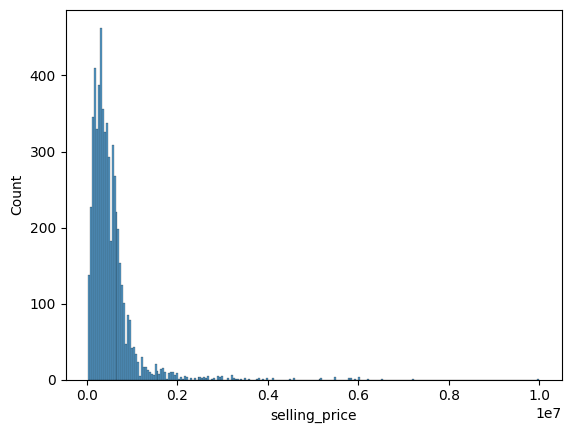

In [79]:
sns.histplot(data= df_train, x= "selling_price");

In [80]:
# переучиваю модель с нормированным таргетом -> качество улучшилось
ridge_reg_ = Ridge(alpha= 10, random_state= 42)

ridge_reg_.fit(OH_X_train_scaller, np.log(y_train))

print('Scores for Ridge and best_params:')
print(f" - Train MSE: {round(MSE(np.exp(ridge_reg_.predict(OH_X_train_scaller)), y_train), 2)}")
print(f" - Test MSE: {round(MSE(np.exp(ridge_reg_.predict(OH_X_test_scaller)), y_test), 2)}")
print()
print(f" - Train R2: {round(r2_score(np.exp(ridge_reg_.predict(OH_X_train_scaller)), y_train), 2)}")
print(f" - Test R2: {round(r2_score(np.exp(ridge_reg_.predict(OH_X_test_scaller)), y_test), 2)}")

Scores for Ridge and best_params:
 - Train MSE: 48979576206.3
 - Test MSE: 105494034533.74

 - Train R2: 0.78
 - Test R2: 0.65


# Часть Бизнесовая (0.5 балла)

Заказчик просил вас посчитать кастомную метрику -- среди всех предсказанных цен на авто посчитать долю предиктов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

<font color='#9933CC'>Сделайте это самостоятельно для лучшей из своих моделей</font>

In [89]:
def business_metrics(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        if (y_pred[i] >= (y_true[i] - y_true[i] * 0.1)) and (y_pred[i] <= (y_true[i] + y_true[i] * 0.1)):
            count += 1
    return count / len(y_test)

y_pred = np.exp(ridge_reg_.predict(OH_X_test_scaller))

business_metrics(y_test, y_pred)

0.276

# Часть 5 (2.5 балла) | Реализация сервиса на FastAPI

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

Сервис на FastApi в файле service.py.

Не получилось вернуть в виде файла с +1 столбцом предсказаний в случае предсказания из csv-файла, поэтому возвращаю просто список предсказаний, как указано в шаблоне

In [99]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()

class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str 
    engine: str
    max_power: str
    torque: str
    seats: float

class Items(BaseModel):
    objects: List[Item]

@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# Часть 6 (1 балл) | Оформление результатов

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете прислать screencast в ТГ
3. Просматривает ноутбук с pure-DS частью
4. Заглядывает в код сервиса
5. Хвалит

# Часть Благодарственная

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

https://drive.google.com/file/d/1LT06nyg9QgVi3r-D5BY-_mQ9TcJQFxJN/view?usp=share_link